In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
path = 'https://stepik.org/media/attachments/lesson/396012/hw_aa.csv'

In [3]:
df = pd.read_csv(path, sep=';')

In [4]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


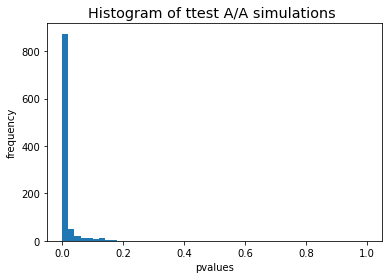

0.935

In [5]:
# запускаем А/А-тест
# значение p-value > 0.05 говорит о том, что выборки имеют статзначимые различия
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Отношение количества симуляций с p-value < 0.05 ко всем симуляциям значительно больше самой вероятности наблюдения статзначимых различий. \
Разбираемся в причинах

In [6]:
# распределение по группам приблизительно равное
df.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

# Задание 1: 
Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки

In [7]:
# группируем по номерам групп и версиям приложений
# смотрим среднее значение покупок пользователей в разных группах
df.groupby(['experimentVariant', 'version'], as_index=False) \
    .agg({'uid': 'count', 'purchase': 'mean'}) \
    .rename(columns={'uid': 'users'})

,experimentVariant,version,users,purchase
0,0,v2.8.0,41283,0.000993
1,0,v2.9.0,11921,0.074658
2,0,v3.7.4.0,4204,0.059943
3,0,v3.8.0.0,5694,0.057604
4,1,v2.8.0,41552,0.045606
5,1,v2.9.0,12033,0.071304
6,1,v3.7.4.0,4221,0.063018
7,1,v3.8.0.0,6110,0.062848


Ответ:
Явно бросается в глаза различие в покупках у пользователей с версией приложения v2.8.0 \
В первой группе ~0.1%, а во второй группе 4.5%

# Задание 2:
Посчитайте pvalue для каждой версии МП

# t-test только для пользователей с версией МП v2.8.0

In [8]:
scipy.stats.ttest_ind(df[(df.experimentVariant == 0) & (df.version == 'v2.8.0')]['purchase'],
                      df[(df.experimentVariant == 1) & (df.version == 'v2.8.0')]['purchase'])

Ttest_indResult(statistic=-42.963540840360324, pvalue=0.0)

p-value = 0 \
Это говорит о наличии статзначимых различий

# t-test только для пользователей с версией МП v2.9.0

In [9]:
scipy.stats.ttest_ind(df[(df.experimentVariant == 0) & (df.version == 'v2.9.0')]['purchase'],
                      df[(df.experimentVariant == 1) & (df.version == 'v2.9.0')]['purchase'])

Ttest_indResult(statistic=0.9979597634962479, pvalue=0.31830895167207446)

p-value > 0.05 \
нет статзначимых различий

# t-test только для пользователей с версией МП v3.7.4.0

In [10]:
scipy.stats.ttest_ind(df[(df.experimentVariant == 0) & (df.version == 'v3.7.4.0')]['purchase'],
                      df[(df.experimentVariant == 1) & (df.version == 'v3.7.4.0')]['purchase'])

Ttest_indResult(statistic=-0.5874925850487471, pvalue=0.5568886771079735)

p-value > 0.05 \
нет статзначимых различий

# t-test только для пользователей с версией МП v3.8.0.0

In [11]:
scipy.stats.ttest_ind(df[(df.experimentVariant == 0) & (df.version == 'v3.8.0.0')]['purchase'],
                      df[(df.experimentVariant == 1) & (df.version == 'v3.8.0.0')]['purchase'])

Ttest_indResult(statistic=-1.1956188950206779, pvalue=0.23186933664059722)

p-value > 0.05 \
нет статзначимых различий

# Задание 3:
Найдите версии, где pvalue < 0.05

Ответ: это версия МП v2.8.0

# Задание 4:
Исключите версию с pvalue < 0.05 из основного датафрейма \
Повторно запустите расчет FPR через A/A. Теперь FPR < альфа

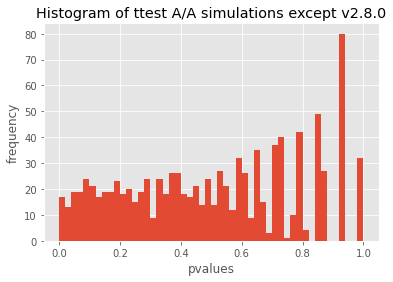

0.04

In [12]:
# запускаем А/А-тест
# значение p-value > 0.05 говорит о том, что выборки имеют статзначимые различия
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations except v2.8.0")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Действительно: при исключении подгрупп с версией приложения v2.8.0, А/А-тест показывает отсутствие значимых различий между выборками (FPR < 0.05)